# PyBaMM Demo

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"


# Set Parameters and Expansion Functions

In [2]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0,
            "Typical electrolyte concentration [mol.m-3]": 1200,
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

## Search Parameters

In [3]:
parameter_values.search("concentration")

Bulk solvent concentration [mol.m-3]	2636.0
EC initial concentration in electrolyte [mol.m-3]	4541.0
Initial concentration in electrolyte [mol.m-3]	1000.0
Initial concentration in negative electrode [mol.m-3]	48.8682
Initial concentration in positive electrode [mol.m-3]	31513.0
Initial plated lithium concentration [mol.m-3]	0.0
Lithium interstitial reference concentration [mol.m-3]	15.0
Maximum concentration in negative electrode [mol.m-3]	28746.0
Maximum concentration in positive electrode [mol.m-3]	35380.0
Negative electrode reference concentration for free of deformation [mol.m-3]	0
Positive electrode reference concentration for free of deformation [mol.m-3]	0
Typical electrolyte concentration [mol.m-3]	1200
Typical plated lithium concentration [mol.m-3]	1000.0


# Set Cell No

In [4]:
cell = 1

## Read Cell data

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [6]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
# if cell_no=='01':
#     c_rate_c = '1C'
#     c_rate_d = '1C'
#     dis_set = " until 3V"
#     # eps_n_data = 0.6234
#     # eps_p_data = 0.4542
# elif cell_no=='13':
#     c_rate_c = 'C/5'
#     c_rate_d = 'C/5'
#     dis_set = " for 150 min"

# Set PyBaMM experiment

In [7]:
# c_rate_c = 'C/20'
c_rate_c = '1.6C'
c_rate_c2 = 'C/3'
# c_rate_c = '1C'

pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        "Charge at "+c_rate_c+" until 3.97V", 
        "Charge at "+c_rate_c2+" until 4.2V", 
        "Hold at 4.2V until C/20",
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        "pressure driven porosity": "true",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()

In [8]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

## Set Additional Parameters

In [9]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

# Simulate

In [10]:
sim_0 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_0 = sim_0.solve(initial_soc=0)

In [23]:
experiment = pybamm.Experiment(
    [
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/20",
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
sim_2 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_2 = sim_2.solve(initial_soc=0)

In [24]:
experiment = pybamm.Experiment(
    [
        "Charge at "+c_rate_c+" until 4.1V", 
        "Charge at "+c_rate_c2+" until 4.2V", 
        "Hold at 4.2V until C/20",
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
sim_1 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_1 = sim_1.solve(initial_soc=0)

# Define plotting variables

In [12]:
spm.variables.search("overpotential")

Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode oxygen reaction overpotential
Negative electrode oxygen reaction overpotential [V]
Negative electrode reaction overpotential
Negative electrode reaction overpotential [V]
Positive electrode oxygen reaction overpotential
Positive electrode oxygen reaction overpotential [V]
Positive electrode reaction overpotential
Positive electrode reaction overpotential [V]
SEI film overpotential
SEI film overpotential [V]
X-averaged SEI film overpotential
X-averaged SEI film overpotential [V]
X-averaged battery concentration overpotential [V]
X-averaged battery reaction overpotential [V]
X-averaged concentration overpotential
X-averaged concentration overpotential [V]
X-averaged electrolyte overpotential
X-averaged electrolyte overpotential [V]
X-averaged negative electrode lithium plating reaction overpotential
X-averaged negative electrode lithium plating reacti

In [13]:
sdfsd

NameError: name 'sdfsd' is not defined

In [14]:
t = sol_0["Time [s]"].entries
I = sol_0["Current [A]"].entries
Q = -sol_0['Discharge capacity [A.h]'].entries
Vt = sol_0["Terminal voltage [V]"].entries

exp = 30e6*sol_0["Cell thickness change [m]"].entries
exp_n = 30e6*sol_0["Negative Electrode thickness change [m]"].entries
exp_p = 30e6*sol_0["Positive Electrode thickness change [m]"].entries
ee_p = sol_0["X-averaged positive electrode porosity"].entries
ee_n = sol_0["X-averaged negative electrode porosity"].entries
ee_s = sol_0["X-averaged separator porosity"].entries
j_n = sol_0["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p = sol_0["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_0["x [m]"].entries
c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries

li_pl_v = sol_0["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c = sol_0["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n = sol_0["X-averaged negative electrode potential [V]"].entries
phi_over_n = sol_0["X-averaged negative electrode reaction overpotential [V]"].entries


In [25]:
t_1 = sol_1["Time [s]"].entries
I_1 = sol_1["Current [A]"].entries
Q_1 = -sol_1['Discharge capacity [A.h]'].entries
Vt_1 = sol_1["Terminal voltage [V]"].entries

exp_1 = 30e6*sol_1["Cell thickness change [m]"].entries
exp_n_1 = 30e6*sol_1["Negative Electrode thickness change [m]"].entries
exp_p_1 = 30e6*sol_1["Positive Electrode thickness change [m]"].entries
ee_p_1 = sol_1["X-averaged positive electrode porosity"].entries
ee_n_1 = sol_1["X-averaged negative electrode porosity"].entries
ee_s_1 = sol_1["X-averaged separator porosity"].entries
j_n_1 = sol_1["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p_1 = sol_1["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_1["x [m]"].entries
c_e_0 = sol_1["Electrolyte concentration [mol.m-3]"].entries

li_pl_v_1 = sol_1["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c_1 = sol_1["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n_1 = sol_1["X-averaged negative electrode potential [V]"].entries
phi_over_n_1 = sol_1["X-averaged negative electrode reaction overpotential [V]"].entries

In [26]:
t_2 = sol_2["Time [s]"].entries
I_2 = sol_2["Current [A]"].entries
Q_2 = -sol_2['Discharge capacity [A.h]'].entries
Vt_2 = sol_2["Terminal voltage [V]"].entries

exp_2 = 30e6*sol_2["Cell thickness change [m]"].entries
exp_n_2 = 30e6*sol_2["Negative Electrode thickness change [m]"].entries
exp_p_2 = 30e6*sol_2["Positive Electrode thickness change [m]"].entries
ee_p_2 = sol_2["X-averaged positive electrode porosity"].entries
ee_n_2 = sol_2["X-averaged negative electrode porosity"].entries
ee_s_2 = sol_2["X-averaged separator porosity"].entries
j_n_2 = sol_2["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p_2 = sol_2["X-averaged positive electrode total interfacial current density [A.m-2]"].entries
x = sol_2["x [m]"].entries
c_e_0 = sol_2["Electrolyte concentration [mol.m-3]"].entries

li_pl_v_2 = sol_2["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
li_pl_c_2 = sol_2["X-averaged lithium plating concentration [mol.m-3]"].entries
phi_n_2 = sol_2["X-averaged negative electrode potential [V]"].entries
phi_over_n_2 = sol_2["X-averaged negative electrode reaction overpotential [V]"].entries

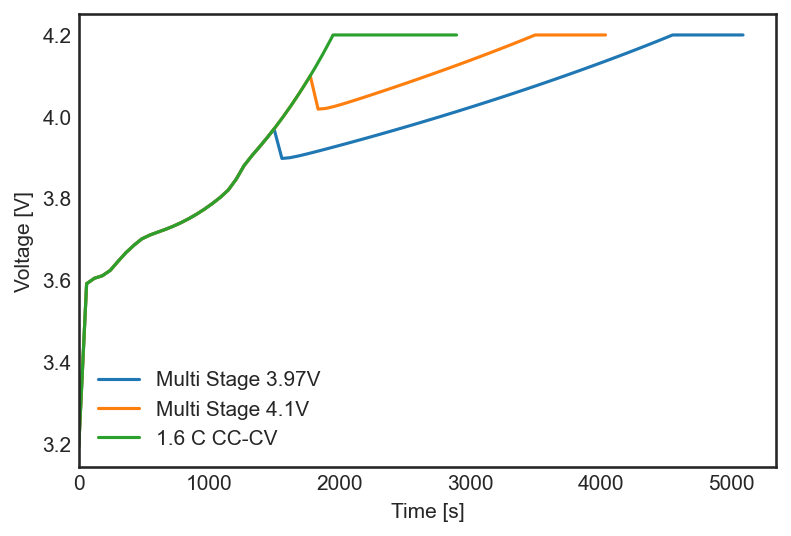

In [30]:
plt.figure()
plt.plot(t,Vt,t_1,Vt_1,t_2,Vt_2)
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Multi Stage 3.97V','Multi Stage 4.1V','1.6 C CC-CV'])
plt.savefig(fig_DIR+'compare_prot_V'+'.png')

In [36]:
print(Q[-1])
print(Q_1[-1])
print(Q_2[-1])

4.843207590298808
4.843205644716532
4.84320295220734


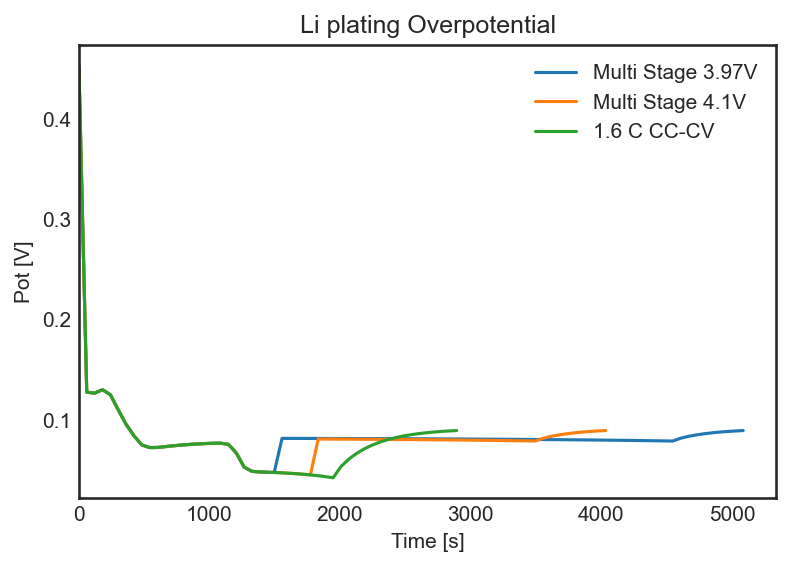

In [31]:
plt.figure()
plt.plot(t,li_pl_v,t_1,li_pl_v_1,t_2,li_pl_v_2)
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Pot [V]')
plt.title('Li plating Overpotential')
plt.legend(['Multi Stage 3.97V','Multi Stage 4.1V','1.6 C CC-CV'])
plt.savefig(fig_DIR+'compare_prot_lipV'+'.png')

In [ ]:
plt.figure()
plt.plot(t,li_pl_c,t_1,li_pl_c_1)
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Conc [mol.m-3]')
plt.title('Li plating Concentration')
plt.legend(['Multi Stage','1.6 C CC-CV'])
# plt.savefig(fig_DIR+'compare_prot_lipc'+'.png')

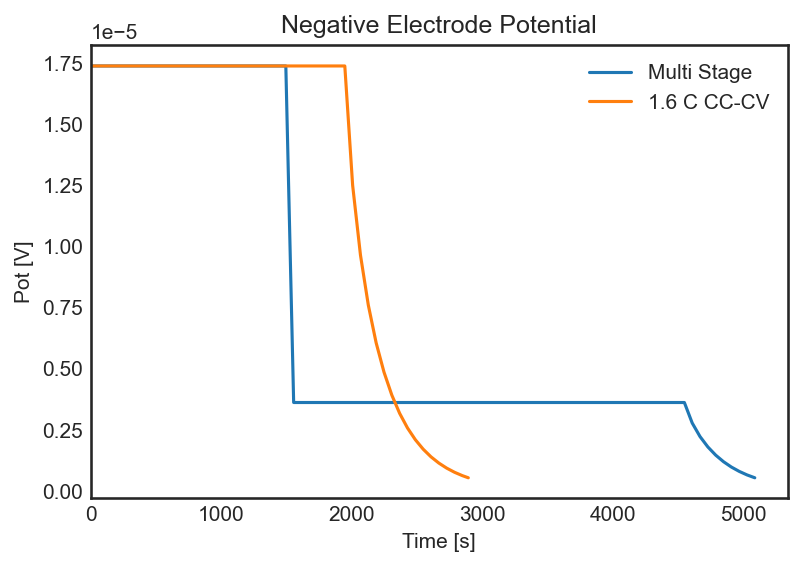

In [18]:
plt.figure()
plt.plot(t,phi_n,t_1,phi_n_1)
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Pot [V]')
plt.title('Negative Electrode Potential')
plt.legend(['Multi Stage','1.6 C CC-CV'])
plt.savefig(fig_DIR+'compare_prot_phiN'+'.png')

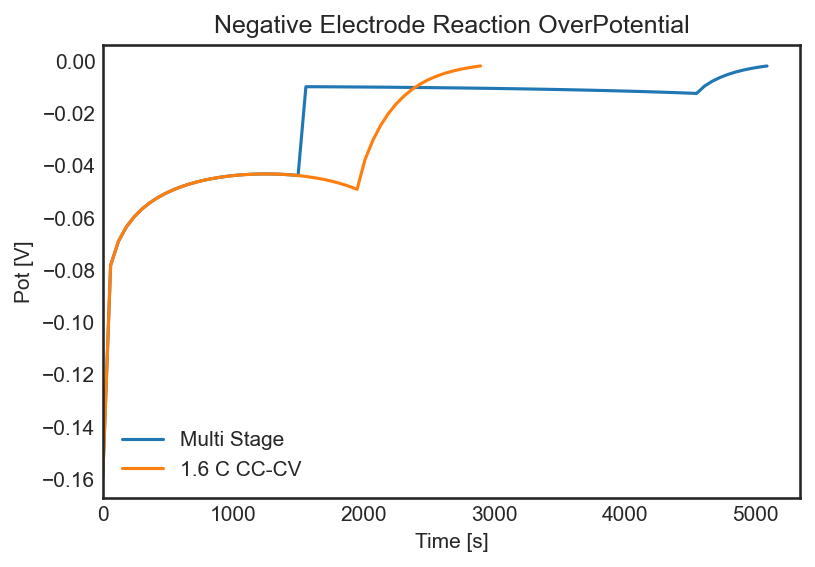

In [19]:
plt.figure()
plt.plot(t,phi_over_n,t_1,phi_over_n_1)
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Pot [V]')
plt.title('Negative Electrode Reaction OverPotential')
plt.legend(['Multi Stage','1.6 C CC-CV'])
plt.savefig(fig_DIR+'compare_prot_phioverN'+'.png')

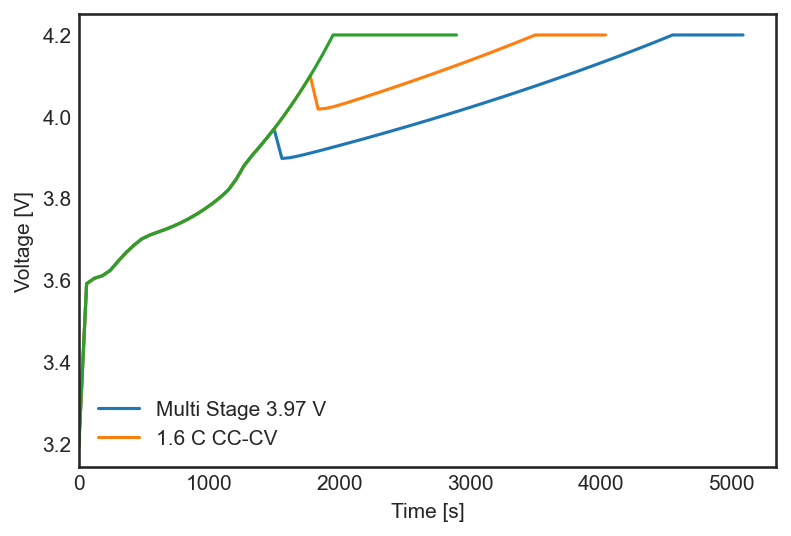